In [6]:
import os
import nibabel as nib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage.measure import shannon_entropy
from scipy import ndimage
from scipy.ndimage.morphology import binary_dilation, binary_erosion

from tqdm import trange


plt.rcParams['figure.figsize'] = [20, 10]

In [4]:
path = "../ScanManTrain61_knee_data/train/"
label_keys = ["FemoralCartilage",
              "LateralFemoralCartilage",
              "LateralMeniscus",
              "LateralTibialCartilage",
              "MedialFemoralCartilage",
              "MedialMeniscus",
              "MedialTibialCartilage",
              "PatellarCartilage",
              "Tibia"]

In [5]:
img = nib.load(path + "images/img_0.nii.gz").get_fdata()
label = nib.load(path + "labels/img_0.nii.gz").get_fdata()

In [8]:
prediction = np.zeros_like(img)

h, w, d = img.shape
for i in trange(h):
    slice = img[i, :, :]
    prediction[i, :, :] += slice

for j in trange(w):
    slice = img[:, j, :]
    prediction[:, j, :] += slice

for k in trange(d):
    slice = img[:, :, k]
    prediction[:, :, k] += slice

prediction /= 3

print(np.sum((img - prediction)**2))

  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

0.0


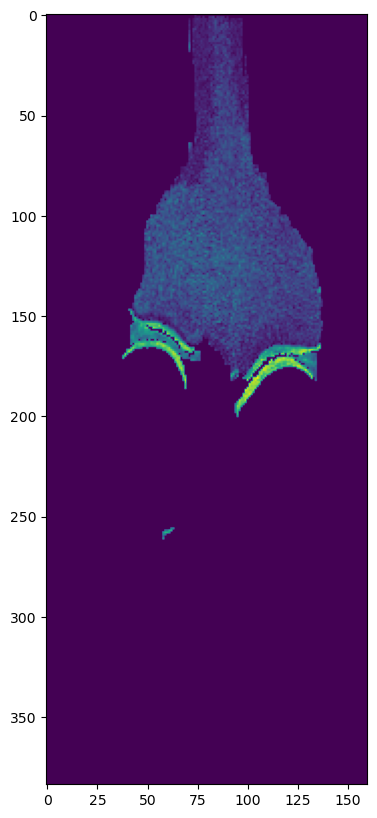

In [14]:
plt.imshow((img * (label != 0).astype(int))[:, 145, :]) 

In [32]:
def get_class_mask(mask, c):
    return (mask == c).astype(int)

def bbox(img):
    # Flatten image along first axis to get bounding box for the two remaining axes
    flat_img = np.max(img, axis=0)
    
    ws = np.any(flat_img, axis=1)
    ds = np.any(flat_img, axis=0)
    wmin, wmax = np.where(ws)[0][[0, -1]]
    dmin, dmax = np.where(ds)[0][[0, -1]]

    return wmin, wmax, dmin, dmax

def center_of_mass(img):
    h, w, d = img.shape
    total = img.sum()
    h_coord = (img.sum(axis=1).sum(axis=1) @ np.arange(h)) / total
    w_coord = (img.sum(axis=2).sum(axis=0) @ np.arange(w)) / total
    d_coord = (img.sum(axis=1).sum(axis=0) @ np.arange(d)) / total
    return np.array([h_coord, w_coord, d_coord])

def BelowCenter(mask, show = False):
    """
    Source: https://github.com/lathomsen/TKR_prediction_from_serial_MRI_and_Clinical_data/blob/main/Extract%20features.ipynb
    """
    [xs, ys, zs] = np.nonzero(mask) # # coordinates are head->toe, front->back, left-right
    X = np.concatenate((xs.reshape(-1,1), ys.reshape(-1,1)),axis=1)
    pca = PCA(n_components=1)
    pca.fit(X)
    mainDir = pca.components_[0]
    mainDir /= np.linalg.norm(mainDir)
    upDir = np.array([mainDir[1], -mainDir[0]])
    meanX = np.mean(xs) # Axial, head->toe
    meanY = np.mean(ys) # Coronal, front->back
    sz = mask.shape
    for x in range(sz[0]):
        for y in range(sz[1]):
            d = np.array([x - meanX, y - meanY])
            up = np.dot(d,upDir)
            if up>0:
                mask[x,y,:] = 0
    return mainDir, upDir, meanX, meanY  # dont need to return, mask is changed inplace

def class_features(image, mask, name):
    mask_image = image * mask

    volume = np.sum(mask)

    mask_idx = np.where(mask==1)
    entropy = shannon_entropy(image[mask_idx])
    mean_intensity = np.mean(image[mask_idx])
    median_intensity = np.median(image[mask_idx])

    opening = binary_dilation(binary_erosion(mask, iterations=2), iterations=2)
    closing = binary_erosion(binary_dilation(mask, iterations=2), iterations=2)
    opening_sum_error = ((mask - opening)**2).sum()
    closing_sum_error = ((mask - closing)**2).sum()

    results = {
        name + "_mean_intensity": mean_intensity,
        name + "_median_intenisty": median_intensity,
        name + "_volume": volume,
        name + "_entropy": entropy,
        name + "_opening": opening_sum_error,
        name + "_closing": closing_sum_error 
    }
    return results

def extract_features(image, mask):
    label_keys = ["FemoralCartilage",
                  "LateralFemoralCartilage",
                  "LateralMeniscus",
                  "LateralTibialCartilage",
                  "MedialFemoralCartilage",
                  "MedialMeniscus",
                  "MedialTibialCartilage",
                  "PatellarCartilage",
                  "Tibia"]
    # Compartments
    lateral_tibial = get_class_mask(mask, 4)
    medial_tibial = get_class_mask(mask, 7)
    femoral = get_class_mask(mask, 2) + get_class_mask(mask, 5)
    lateral_meniscus = get_class_mask(mask, 3)
    medial_meniscus = get_class_mask(mask, 6)
    
    # Crop femoral cartilage to tibial cartilage bounding box
    lt_wmin, lt_wmax, lt_dmin, lt_dmax = bbox(lateral_tibial)
    mt_wmin, mt_wmax, mt_dmin, mt_dmax = bbox(medial_tibial)
    
    femoral_crop = np.zeros_like(femoral)
    femoral_lt_bbox = femoral[:, lt_wmin:lt_wmax + 1, lt_dmin:lt_dmax + 1]
    femoral_mt_bbox = femoral[:, mt_wmin:mt_wmax + 1, mt_dmin:mt_dmax + 1]
    femoral_crop[:, lt_wmin:lt_wmax + 1, lt_dmin:lt_dmax + 1] = femoral[:, lt_wmin:lt_wmax + 1, lt_dmin:lt_dmax + 1]
    femoral_crop[:, mt_wmin:mt_wmax + 1, mt_dmin:mt_dmax + 1] = femoral[:, mt_wmin:mt_wmax + 1, mt_dmin:mt_dmax + 1]
    
    # PCA cut
    # TODO replace with own version of BelowCenter instead of Lærke's
    BelowCenter(femoral_crop)
    lateral_femoral = np.zeros_like(femoral)
    lateral_femoral[:, lt_wmin:lt_wmax + 1, lt_dmin:lt_dmax + 1] = femoral_crop[:, lt_wmin:lt_wmax + 1, lt_dmin:lt_dmax + 1]

    medial_femoral = np.zeros_like(femoral)
    medial_femoral[:, mt_wmin:mt_wmax + 1, mt_dmin:mt_dmax + 1] = femoral_crop[:, mt_wmin:mt_wmax + 1, mt_dmin:mt_dmax + 1]

    # Image features
    image_mean_intensity = np.mean(image)
    image_median_intensity = np.median(image)
    
    lateral_tibial_results = class_features(image, lateral_tibial, "lateral_tibial_cartilage")

    medial_tibial_results = class_features(image, medial_tibial, "medial_tibial_cartilage")

    lateral_femoral_results = class_features(image, lateral_femoral, "lateral_femoral_cartilage")

    medial_femoral_results = class_features(image, medial_femoral, "medial_femoral_cartilage")

    lateral_meniscus_results = class_features(image, lateral_meniscus, "lateral_meniscus")

    medial_meniscus_results = class_features(image, medial_meniscus, "medial_meniscus")

    results = {
        "image_mean_intensity": image_mean_intensity,
        "image_median_intensity": image_median_intensity,
        **lateral_tibial_results,
        **medial_tibial_results,
        **lateral_femoral_results,
        **medial_femoral_results,
        **lateral_meniscus_results,
        **medial_meniscus_results
    }

    return results

In [33]:
extract_features(img, label)

{'image_mean_intensity': 51.132405810885956,
 'image_median_intensity': 37.0,
 'lateral_tibial_cartilage_mean_intensity': 163.79338842975207,
 'lateral_tibial_cartilage_median_intenisty': 166.0,
 'lateral_tibial_cartilage_volume': 9922,
 'lateral_tibial_cartilage_entropy': 7.27121837162273,
 'lateral_tibial_cartilage_opening': 4914,
 'lateral_tibial_cartilage_closing': 269,
 'medial_tibial_cartilage_mean_intensity': 152.46413321947054,
 'medial_tibial_cartilage_median_intenisty': 154.0,
 'medial_tibial_cartilage_volume': 11710,
 'medial_tibial_cartilage_entropy': 7.082672265765045,
 'medial_tibial_cartilage_opening': 9983,
 'medial_tibial_cartilage_closing': 268,
 'lateral_femoral_cartilage_mean_intensity': 189.49576960624796,
 'lateral_femoral_cartilage_median_intenisty': 193.0,
 'lateral_femoral_cartilage_volume': 12292,
 'lateral_femoral_cartilage_entropy': 6.791861854023204,
 'lateral_femoral_cartilage_opening': 3987,
 'lateral_femoral_cartilage_closing': 244,
 'medial_femoral_cart